In [1]:
# Simulate a stationary AR(2) process. Use the ArmaProcess function from the statsmodels
# library and simulate this process:
# yt = 0.33yt –1 + 0.50yt –2
# 1 For this exercise, generate 1,000 samples.
# from statsmodels.tsa.arima_process import ArmaProcess
# import numpy as np
# np.random.seed(42)
# ma2 = np.array([1, 0, 0])
# ar2 = np.array([1, -0.33, -0.50])
# AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)


In [2]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [3]:
np.random.seed(151)

ar2 = np.array([1, -0.33, -0.50])
ma2 = np.array([1, 0, 0])

ar2_process = ArmaProcess(ar=ar2,ma=ma2).generate_sample(1000)


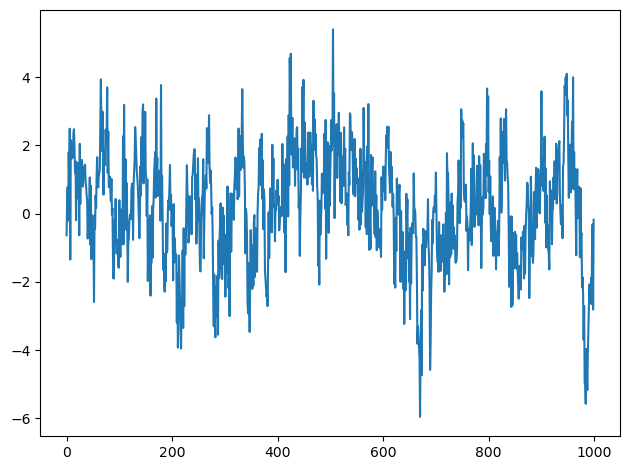

In [4]:
#Plot your simulated moving average.

plt.plot(ar2_process)
plt.tight_layout()

In [5]:
# Run the ADF test, and check if the process is stationary.

adf_result = adfuller(ar2_process)

print(f"ADF_Stat: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

ADF_Stat: -7.218581660401808
p-value: 2.140775057364971e-10


##### The process is stationary. It has a high negative value of adf_statistic and p value is less than 0.05.

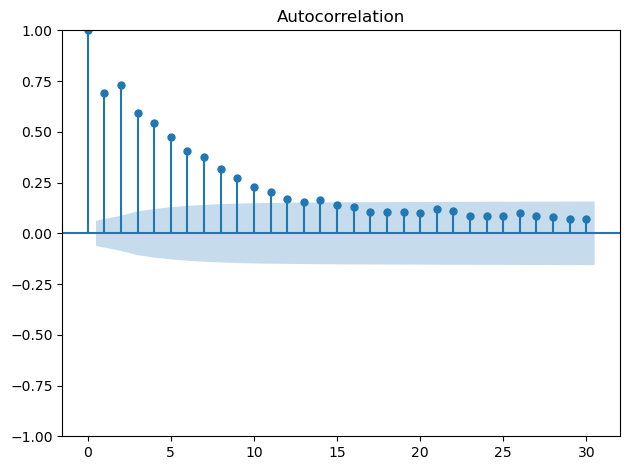

In [6]:
# Plot the ACF. Is it slowly decaying?


plot_acf(ar2_process)
plt.tight_layout()

There is a trend in the coefficients after lag2. Hence we check the pacf.

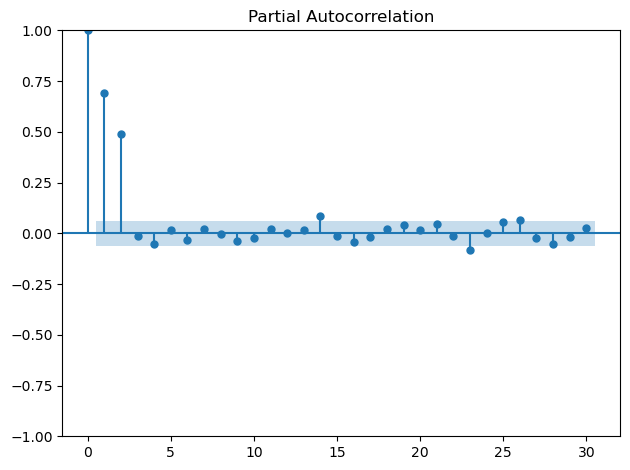

In [11]:
#Plot the PACF. Are there significant coefficients after lag 2?

plot_pacf(ar2_process)
plt.tight_layout()

There are no significant coefficients after lag2.

In [9]:
import pandas as pd
df = pd.DataFrame({'values':ar2_process})
df.head()

,values
0,-0.636738
1,0.321435
2,0.777913
3,-0.206705
4,1.788525


In [10]:
# Separate your simulated series into train and test sets. Take the first 800 timesteps for the train set, and assign the rest to the test set.

train = ar2_process[:800]
test = ar2_process[800:]

In [70]:
Make forecasts over the test set. Use the historical mean method, last known
value method, and an AR(2) model. Use the rolling_forecast function, and
use a window length of 2.

In [15]:
def rolling_forecast(data: np.array, train_len: int, horizon: int, window: int, method: str)-> list:
    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []
        for i in range(train_len,total_len,window):
            mean = np.mean(data[0:i])
            # calculate the mean for the whole train data until that index and populate it for the next window length records as forecasted value
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean
    
    if method == 'last':
        pred_last = []
        for i in range(train_len,total_len,window):
            last_value = data[:i][-1]
            pred_last.extend(last_value for _ in range(window))

        return pred_last
    
    if method == 'AR':
        pred_AR = []
        for i in range(train_len,total_len,window):
            model = SARIMAX(data[:i],order=(2,0,0))
            results = model.fit(disp = True)
            predictions = results.get_prediction(0,i+window-1)
            # get the predictions for all the data plus window size(2 in this case)
            # The last window size number of predictions are the out of sample predictions
            oos_pred = predictions.predicted_mean[-window:]
            # print(oos_pred)
            pred_AR.extend(oos_pred)
        return pred_AR
    



In [16]:
import pandas as pd
pred_df = pd.DataFrame({'value':test}, index= range(800,1000))

# arguments for the rolling forecast function
Train_len = len(train)
Horizon = len(test)
Window = 2

pred_mean = rolling_forecast(ar2_process,Train_len,Horizon,Window,'mean')
pred_last = rolling_forecast(ar2_process,Train_len,Horizon,Window,'last')
pred_AR = rolling_forecast(ar2_process,Train_len,Horizon,Window,'AR')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last
pred_df['pred_AR'] = pred_AR

pred_df.head()


,value,pred_mean,pred_last_value,pred_AR
800,0.632678,0.254668,3.430094,1.713843
801,1.544919,0.254668,3.430094,2.282648
802,-0.012275,0.256748,1.544919,0.833456
803,1.085722,0.256748,1.544919,1.047420
804,-0.330477,0.257445,1.085722,0.357516


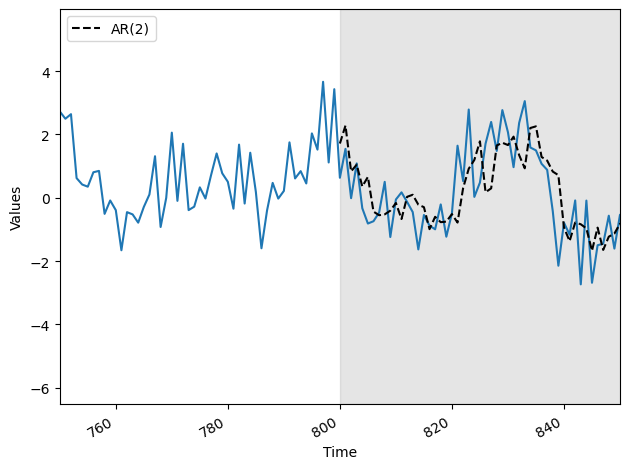

In [17]:
fig, ax = plt.subplots()

ax.plot(ar2_process)
# ax.plot(pred_df['value'], 'b-', label='actual')
# ax.plot(pred_df['pred_mean'], 'g:', label='mean')
# ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_AR'], 'k--', label='AR(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Values')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

ax.set_xlim(750, 850)

fig.autofmt_xdate()
plt.tight_layout()

In [18]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['value'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['value'], pred_df['pred_last_value'])
mse_AR = mean_squared_error(pred_df['value'], pred_df['pred_AR'])

print(mse_mean, mse_last, mse_AR)

3.2511654134981196 1.3608903276901114 1.0726468591275948


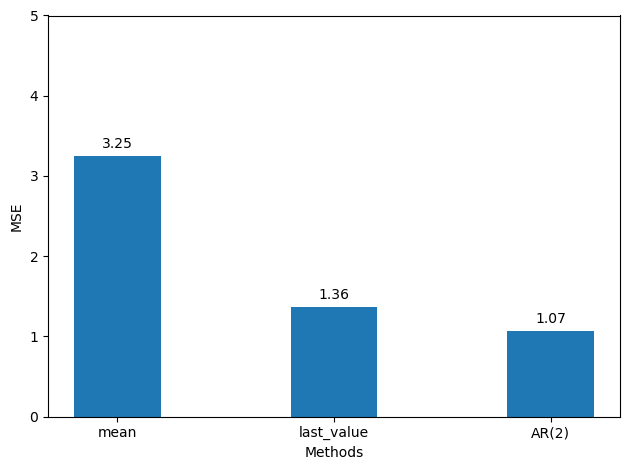

In [20]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(2)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()



AR2 model gave the least mean_squared_error, It can be considered to be the best model